In [ ]:
dont_edit

# Forward encoding model based on Pim Mostert Decoding toolbox



In [1]:
!pwd

/Users/junjieji/Desktop/master-thesis


In [2]:
import sys

# %matplotlib qt
from scipy.io import loadmat
import numpy as np
import pandas as pd
import mat73

import inspect #path_fun = inspect.getfile(StratifiedKFold)
import matplotlib.pyplot as plt
import DecToolbox as dt
import mne
import os
import random

from statsmodels.tsa.stattools import coint


In [3]:
path_utils = '/decoding_toolbox_py/helper_funcs' 
sys.path.append(path_utils)

# Variables

In [4]:
''' VARIABLES '''

dataset = 'eeg'

amount_of_subjects = 24 # Change the range so the process is faster

numC = 8
angles = [i * 180./numC for i in range(numC)]
x_labels = np.array(angles)

resample = False # speeds up the procees but showing worse results overall
if resample: resample_frequency = 100 # in Hz, original freq is 500Hz

cfg_stim = dict()
cfg_stim['kappa'] = 4
cfg_stim['NumC'] = numC
cfg_stim['Tuning'] = 'vonmises'
# cfg_stim['Tuning'] = 'halfRectCos'
cfg_stim['offset'] = 0

cfg_train = dict()
cfg_train['gamma'] = 0.1
cfg_train['demean'] = True
cfg_train['returnPattern'] = True

cfg_test = dict()
cfg_test['demean'] = 'traindata'

# Loading & preparing orientation data

In [5]:
'''EEG Dataset'''
if amount_of_subjects > 26: amount_of_subjects = 26
subjs_list = ['s{:02d}'.format(i) for i in range(1, amount_of_subjects+1) if i != 6 ] 
path = 'Cond_CJ_EEG'

epochs = []
all_epochs = []
all_rawdata = []
all_st_epochs = []
all_st_rawdata = []
for subject_id in subjs_list:
    preproc_path = os.path.join(path, subject_id)
    
    epoch = mne.read_epochs(os.path.join(preproc_path, 'main_epo.fif'), verbose=False)
    epochs.append(epoch.average())
    all_epochs.append(epoch)
    all_rawdata.append({'epoch_dat': epoch.get_data(), 'metadata': epoch.metadata})
    st_epoch = mne.read_epochs(os.path.join(preproc_path, 'mainstim_epo.fif'), verbose=False)
    # print(st_epoch.info['sfreq'])
    if resample: 
        print('Frequency before:', st_epoch.info['sfreq'])
        st_epoch = st_epoch.resample(resample_frequency)
        print('Frequency after:' ,st_epoch.info['sfreq'])
    all_st_epochs.append(st_epoch)
    all_st_rawdata.append({'epoch_dat': st_epoch.get_data(), 'metadata': st_epoch.metadata})
gvaverage = mne.grand_average(epochs[:])

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Frequency before: 500.0
Frequency after: 100.0
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Frequency before: 500.0
Frequency after: 100.0
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Frequency before: 500.0
Frequency after: 100.0
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Frequency before: 500.0
Frequency after: 100.0
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Frequency before: 500.0
Frequency after: 100.0
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Frequency before: 500.0
Frequency after: 100.0
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Frequency before: 500.0
Frequency after: 100.0
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Frequency before: 500.0
Frequen

In [6]:
if dataset == 'eeg':
    print(epoch.metadata.shape)
    display(epoch.metadata.head())

(250, 35)


,index,subj,nblock,ntrial,nrep,trial_type,cond-1,cond,rDV,DV,...,d5,d6,o1,o2,o3,o4,o5,o6,confi-1,conf_lvl-1
866,0,s10,0,0,0,repeat,0,0,0.168679,-0.2,...,-0.990851,0.274749,1.825,0.633,0.264,1.336,3.138,2.641,0.00,L
879,1,s10,0,0,1,repeat,0,0,0.168679,-0.2,...,-0.990851,0.274749,1.825,0.633,0.264,1.336,3.138,2.641,-0.15,L
892,2,s10,0,0,2,repeat,0,0,0.168679,-0.2,...,-0.990851,0.274749,1.825,0.633,0.264,1.336,3.138,2.641,-0.75,L
905,3,s10,0,1,0,nonrepeat,0,0,0.390601,-0.1,...,-0.451988,-0.529939,2.594,0.181,0.626,2.766,1.786,2.957,0.65,H
918,4,s10,0,1,1,nonrepeat,0,0,0.390601,-0.1,...,-0.451988,-0.529939,2.594,0.181,0.626,2.766,1.786,2.957,0.55,H


In [7]:
if dataset == 'eeg':
    print(st_epoch.metadata.shape)
    display(st_epoch.metadata.head())

(1513, 23)


,subj,trial_type,nblock,ntrial,nrep,stim_cond,cond-1,cong_deci,cong_stim,cond,...,corr-1,correct,confi,conf_lvl,correct-1,RT,stim,dv,orient,ov
868,s10,repeat,0,0,0,C,0,C,C,0,...,0,1,-0.15,L,0,6.028227,d1,-0.352676,104.564798,0.676338
869,s10,repeat,0,0,0,D,0,I,I,0,...,0,1,-0.15,L,0,6.028227,d2,0.611921,36.268228,-0.194039
870,s10,repeat,0,0,0,C,0,C,C,0,...,0,1,-0.15,L,0,6.028227,d3,-0.327730,15.126086,-0.663865
871,s10,repeat,0,0,0,C,0,C,C,0,...,0,1,-0.15,L,0,6.028227,d4,-0.402096,76.547161,0.701048
872,s10,repeat,0,0,0,C,0,C,C,0,...,0,1,-0.15,L,0,6.028227,d5,-0.990851,179.794156,-0.995426


# Procedure for multisubject

In [8]:
from DecToolbox import CV_encoder, CreateFolds

nSubj = len(subjs_list)
preds = [None] * nSubj
G = [None] * nSubj

for subj in range(nSubj):
    print(subj)
    time = all_st_epochs[subj].times
    label = all_st_epochs[subj].ch_names
    Y = all_st_rawdata[subj]['epoch_dat']
    Y = np.einsum('kji->jik', Y)
    Y = np.delete(Y, 25, axis=0)

    X = np.array(all_st_rawdata[subj]['metadata'].orient)
    X = np.digitize(X, bins = np.array(angles))-1.
    phi = X * (180./numC)
    numF, numT, numN = Y.shape

    G[subj] = X.copy() 
    
    CONDS = np.unique(G[subj])
    nConds = CONDS.size
    nfold = 5
    FoldsIdx = dt.CreateFolds(G[subj], Y, nfold)
    
    design, sortedesign = dt.stim_features(phi, cfg_stim)
    
    Xhat = np.zeros([numC,numN, numT])
    for it in range(numT):
        cfg = dict()
        cfg['cfgE'] = {'gamma': 0.01, 'demean' : True, 'returnPattern' : True}
        cfg['cfgD'] = {'demean' : 'traindata'}
        Xhat[:,:,it] = CV_encoder(design, Y, it, cfg, FoldsIdx)
    
    preds[subj] = Xhat   

0
1
2
3
4
5
6
7
8


In [9]:
m_centered = np.zeros((numC,numC, numT, nSubj))
for ival, isubj in enumerate(subjs_list):
    Xhat = preds[ival]
    Xhat_centered = 0*Xhat.copy()
    
    for ic in range(numC): # here trials that match similar label orientation are shifted together x positions (np.roll)
        Xhat_centered[:, G[ival] == ic,:] = np.roll(Xhat[:,G[ival] == ic,:], -ic, axis = 0)
        m_centered[:,ic, :, ival] =  np.mean( Xhat_centered[:,  G[ival] == ic, :], axis = 1)

print(Xhat.shape)

(8, 1513, 40)


In [10]:
print(m_centered.shape)

(8, 8, 40, 9)


In [11]:
Xhat_centeredmean = np.mean( m_centered, axis = 1)
print(Xhat_centeredmean.shape)
Xhat_centeredmean = np.mean( Xhat_centeredmean, axis = 2)
print(Xhat_centeredmean.shape)

(8, 40, 9)
(8, 40)


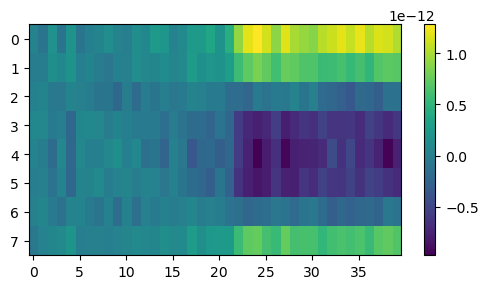

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
plt.imshow(Xhat_centeredmean,aspect='auto')
plt.colorbar()


# crossmodal

In [13]:
from DecToolbox import CV_TG_encoder

nSubj = len(subjs_list)
Zpreds = [None] * nSubj
G = [None] * nSubj

for subj in range(nSubj):
    print(subj)
    time = all_st_epochs[subj].times
    label = all_st_epochs[subj].ch_names
    Y = all_st_rawdata[subj]['epoch_dat']
    Y = np.einsum('kji->jik', Y)
    Y = np.delete(Y, 25, axis=0)

    X = np.array(all_st_rawdata[subj]['metadata'].orient)
    X = np.digitize(X, bins = np.array(angles))-1.
    phi = X * (180./numC)
    numF, numT, numN = Y.shape

    G[subj] = X.copy() 
    
    CONDS = np.unique(G[subj])
    nConds = CONDS.size
    nfold = 5
    FoldsIdx = dt.CreateFolds(G[subj], Y, nfold)
    
    design, sortedesign = dt.stim_features(phi, cfg_stim)
    
    Xhat = np.zeros([numC,numN, numT, numT])
    for it in range(numT):
        cfg = dict()
        cfg['cfgE'] = {'gamma': 0.01, 'demean' : True, 'returnPattern' : True}
        cfg['cfgD'] = {'demean' : 'traindata'}
        Xhat[:,:,it,:] = CV_TG_encoder(design, Y, it, cfg, FoldsIdx)
    
    Zpreds[subj] = Xhat   

0
1
2
3
4
5
6
7
8


In [38]:
m_centered = np.zeros((numC,numC, numT,numT, nSubj))
for ival, isubj in enumerate(subjs_list):
    Zhat = Zpreds[ival]
    Zhat_centered = 0*Zhat.copy()
    
    for ic in range(numC): # here trials that match similar label orientation are shifted together x positions (np.roll)
        Zhat_centered[:, G[ival] == ic,:] = np.roll(Zhat[:,G[ival] == ic,:], -ic, axis = 0)
        m_centered[:,ic, :, :, ival] =  np.mean( Zhat_centered[:,  G[ival] == ic, :], axis = 1)

In [40]:
print(Zhat.shape, m_centered.shape)

(8, 1513, 40, 40) (8, 8, 40, 40, 9)


(8, 40, 40, 9)


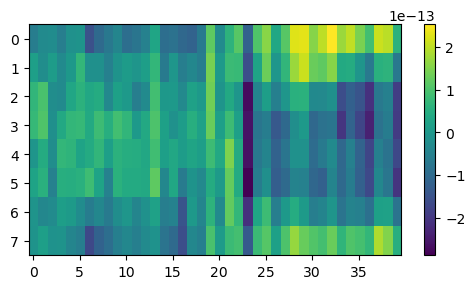

In [42]:
Zhat_centered_subjmean = np.mean(m_centered,axis=1)
print(Zhat_centered_subjmean.shape)
Zhat_timecentered = np.mean(Zhat_centered_subjmean, axis = 3)
Zhat_timecentered = np.mean(Zhat_timecentered, axis = 2)


fig, ax = plt.subplots(1, 1, figsize=(6, 3))
plt.imshow(Zhat_timecentered,aspect='auto')
plt.colorbar()


In [43]:
r = np.zeros((numT, numT))

for it1 in range(numT):
    for it2 in range(numT):
        # Kernel to back project channel outputs to orientation space
        kernel = np.exp(1j * (np.linspace(0, numC-1,numC)*(2*np.pi/numC)))
        Z = kernel @ Xhat[:,:, it1, it2]

        theta = np.mod(np.angle(Z), 2*np.pi) * (180/np.pi) / 2    # Decoded orientation (retain the module of the complex number)

        rs = np.mean(np.exp(1j * (theta - phi) * (np.pi/180)*2)) # correlation between decoded and presented orientation
        r[it1, it2] = np.abs(rs) * np.cos(np.angle(rs))
        r
'''1 min mac'''

'1 min mac'

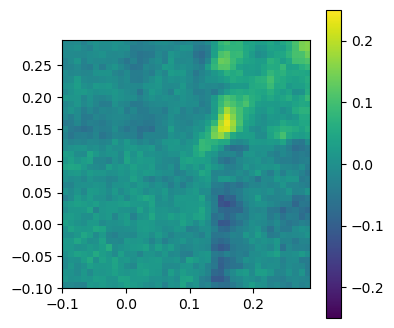

In [44]:
time_labels = [0, 0.2, 0.4, 0.6]
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plt.imshow(r, aspect= 1, interpolation = None, vmin = -0.25, vmax = 0.25, origin = 'lower',extent=[time[0],time[-1],time[0],time[-1]])
plt.colorbar()